<a href="https://colab.research.google.com/github/qiuhuasheng1107/project_pytorch_exercise/blob/main/torch_student_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

from torch.utils.data import random_split
import torchvision.transforms as transforms

import matplotlib
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np

In [ ]:
df = pd.read_csv('student.csv')

In [ ]:
df_set = df[['gender', 'math_score', 'reading_score', 'writing_score']]

In [ ]:
new_df = pd.get_dummies(data=df_set, columns=['gender'], drop_first=True)

In [ ]:
feature_set = new_df[['gender_male','math_score', 'reading_score']]
feature_set.head()

,gender_male,math_score,reading_score
0,0,72,72
1,0,69,90
2,0,90,95
3,1,47,57
4,1,76,78


In [ ]:
label = df[['writing_score']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(feature_set, label, 
                                                    test_size=0.1, random_state=42)

In [ ]:
inputs = torch.from_numpy(X_train.values).float()
targets = torch.from_numpy(y_train.values).float()
print(inputs.dtype)

torch.float32


In [ ]:
train = TensorDataset(inputs, targets)
train[0:3]
#print(len(train))

(tensor([[ 1., 73., 78.],
         [ 1., 66., 57.],
         [ 1., 67., 57.]]), tensor([[72.],
         [52.],
         [53.]]))

In [ ]:
val_size = 100
train_size = len(train) - val_size

train_ds, val_ds = random_split(train, [train_size, val_size])
len(train_ds), len(val_ds)

(800, 100)

In [ ]:
batch_size = 128
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size)

# Model Construction

In [ ]:
class NewModel(nn.Module):
  def __init__(self, in_size, hidden_size, out_size):
      super().__init__()
      self.linear1 = nn.Linear(in_size, hidden_size)
      self.linear2 = nn.Linear(hidden_size, out_size)
  
  def forward(self, xb):
    out = self.linear1(xb)
    out = F.relu(out)
    out = self.linear2(out)
    return out

  def training_step(self, batch):
    xb, yb = batch
    out = self(xb)
    loss = F.mse_loss(out, yb)
    return loss
  
  def validation_step(self, batch):
    xb, yb = batch
    out = self(xb)
    loss = F.mse_loss(out, yb)
    return {'val_loss': loss}
  
  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    return {'val_loss': epoch_loss.item()}
  
  def epoch_end(self, epoch, result):
    print(epoch, result['val_loss'])

model = NewModel(3, 16, 1)

In [ ]:
loss_fn = F.mse_loss
opt = torch.optim.SGD(model.parameters(), lr=1e-5)

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [ ]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    train_losses, history = [],[]
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

        train_losses.append(loss.detach())
        

    return train_losses, history

In [ ]:
evaluate(model, val_dl)

{'val_loss': 3336.46337890625}

In [ ]:
evaluate(model, val_dl)

{'val_loss': 3336.46337890625}

In [ ]:
train_losses, val_losses = fit(50, 0.001, model, train_dl, val_dl)

0 371.7451171875
1 369.2864990234375
2 366.7920837402344
3 364.3603210449219
4 362.0498046875
5 359.7901611328125
6 357.5641784667969
7 355.3746337890625
8 353.31427001953125
9 351.29241943359375
10 349.3125305175781
11 347.3446960449219
12 345.4532775878906
13 343.5986633300781
14 341.7144470214844
15 339.84259033203125
16 338.0160217285156
17 336.3858337402344
18 334.74481201171875
19 333.1546936035156
20 331.56378173828125
21 330.1448059082031
22 328.7069091796875
23 327.3011474609375
24 325.88946533203125
25 324.58209228515625
26 323.19415283203125
27 322.0191345214844
28 320.8002014160156
29 319.6483154296875
30 318.576904296875
31 317.5428161621094
32 316.47503662109375
33 315.4195556640625
34 314.3699951171875
35 313.3619384765625
36 312.3221130371094
37 311.43035888671875
38 310.45965576171875
39 309.44158935546875
40 308.5084228515625
41 307.6200256347656
42 306.7635498046875
43 305.8978576660156
44 305.12969970703125
45 304.3275146484375
46 303.55108642578125
47 302.813018798

In [ ]:
val_plots = pd.DataFrame(val_losses)

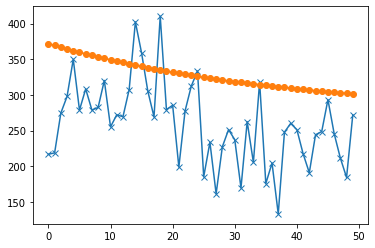

In [ ]:
plt.plot(train_losses, '-x')
plt.plot(val_plots, '-o')
plt.show()